The following model is the standard GAN which is part of **Exercise 1**. It is a very simple example and you can improve it by adding convolutions and many other ideas that we talked about if you want. Fill in the missing pieces and train it.


In [1]:
%matplotlib inline

import os
import numpy as np
import math
import multiprocessing
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.optim.optimizer import Optimizer, required
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs("images_gan", exist_ok=True)
os.makedirs("images_cgan", exist_ok=True)

batch_size = 128                               #size of the batches
lr = 0.0005                                    #adam: learning rate
b1 = 0.5                                       #adam: decay of first order momentum of gradient
b2 = 0.999                                     #adam: decay of second order momentum of gradient
n_cpu = multiprocessing.cpu_count()            #number of cpu threads to use during batch generation
latent_dim = 100                               #dimensionality of the latent space
img_size = 28                                  #size of each image dimension
channels = 1                                   #number of image channels
sample_interval = 400                          #interval between image samples


img_shape = (channels, img_size, img_size)
torch.manual_seed(42)

In [2]:
def to_onehot(digits, num_classes):
    """ [[3]] => [[0, 0, 1]]
    """
    labels_onehot = torch.zeros(digits.shape[0], num_classes).to(device)
    labels_onehot.scatter_(1, digits.view(-1, 1), 1)
    return labels_onehot

def plot_class_distributions(y_pred, num_classes):
    class_distributions = [np.sum(y_pred == i) for i in range(num_classes)]
    plt.bar(list(range(num_classes)), class_distributions, tick_label=list(range(num_classes)))
    plt.ylabel("Number of predictions")
    plt.xlabel("Class")
    plt.plot()
    
class GeneratorBlock(nn.Module):
    def __init__(self, in_feat, out_feat, activation, use_norm=True):
        super().__init__()
        self.dense = nn.Linear(in_feat, out_feat)
        self.activation = activation
        if use_norm:
            self.bn = nn.BatchNorm1d(out_feat, 0.8)
        else:
            self.bn = None
            
    def forward(self, x):
        x = self.dense(x)
        x = self.activation(x)
        if self.bn != None:
            x = self.bn(x)
        return x
        

class Generator(nn.Module):
    def __init__(self, num_classes=0):
        super().__init__()
        self.b1 = GeneratorBlock(latent_dim + num_classes, 128, activation=nn.LeakyReLU(0.2), use_norm=False)
        self.b2 = GeneratorBlock(128, 256, activation=nn.LeakyReLU(0.2))
        self.b3 = GeneratorBlock(256, 512, activation=nn.LeakyReLU(0.2))
        self.b4 = GeneratorBlock(512, 1024, activation=nn.LeakyReLU(0.2))
        self.b5 = GeneratorBlock(1024, 1 * 28 * 28, activation=nn.Tanh(), use_norm=False)

    def forward(self, x, y=None):
        if y != None:
            x =  torch.cat((x, y), dim=1)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = x.view(-1, 1, 28, 28)
        return x


class Discriminator(nn.Module):
    def __init__(self, num_classes=0, use_sigmoid=True):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28 + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
        self.use_sigmoid = use_sigmoid

    def forward(self, x, y=None):
        x = x.view(x.shape[0], -1)
        if y != None:
            x =  torch.cat((x, y), dim=1)
        x = self.model(x)
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x

In [3]:
# Loss function
bce_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)
bce_loss.to(device)

# Configure data loader
os.makedirs("./mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset(
        [
            datasets.MNIST(
                "./mnist",
                train=True,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            ),
            datasets.MNIST(
                "./mnist",
                train=False,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            ),
        ]
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu
)
     
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [4]:
# ----------
#  Training
# ----------

def train_loop(generator, discriminator, dataloader, optimizer_g, optimizer_d, loss_func, num_epochs, with_labels, use_wasserstein):
    iterations = len(dataloader)
    gen_losses, disc_losses = [], [] 
    for epoch in range(num_epochs):
        running_gen_loss = 0.0
        running_disc_loss = 0.0
        for i, (real_imgs, y) in enumerate(dataloader):

            real_imgs =  real_imgs.to(device)
            if with_labels:
                y = to_onehot(y.to(device), 10)
            else:
                y = None

            # -----------------
            #  Train Generator
            # -----------------

            # WGANs train the discriminator more often than the generator
            if i % 5 == 0 or not use_wasserstein:
                optimizer_G.zero_grad()

                z = torch.randn((real_imgs.shape[0], latent_dim)).to(device)
                gen_imgs = generator(z, y)

                y_pred_fake = discriminator(gen_imgs)

                if use_wasserstein:
                    g_loss = loss_func(y_pred_fake)
                else:
                    g_loss = loss_func(y_pred_fake, torch.zeros_like(y_pred_fake))
                g_loss.backward()
                optimizer_G.step()
 
            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()
            
            gen_imgs = generator(z, y)

            y_pred_real = discriminator(real_imgs, y)
            y_pred_fake = discriminator(gen_imgs, y)
            
            if use_wasserstein:
                d_loss = loss_func(y_pred_real) - loss_func(y_pred_fake)
            else:
                real_loss = loss_func(y_pred_real, torch.zeros_like(y_pred_real))
                fake_loss = loss_func(y_pred_fake, torch.ones_like(y_pred_real))
                d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # clip weights of discriminator when using WGAN
            if use_wasserstein:
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

            running_gen_loss += g_loss.item()
            running_disc_loss += d_loss.item()

            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:
                # You can also safe samples in your drive & maybe save your network as well
                save_image(gen_imgs.data[:25], "images_gan/GAN-%d.png" % batches_done, nrow=5, normalize=True)

        gen_loss = running_gen_loss / iterations
        disc_loss = running_disc_loss / iterations
        loss = gen_loss + disc_loss
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        print(f"Epoch {epoch + 1}/{num_epochs} ==> loss: {loss}, gen_loss: {gen_loss}, disc_loss: {disc_loss}")
        grid = make_grid(gen_imgs.data[:25], nrow=5, normalize=True).cpu().numpy()
        # Channels first (PyTorch) to channels last (matplotlib)
        grid = np.moveaxis(grid, 0, -1)
        plt.imshow(grid, cmap='gray')
        plt.axis('off')
        plt.show()
    return gen_losses, disc_losses

Epoch 1/20 ==> loss: 1.4898569356970204, gen_loss: 0.8851084861448085, disc_loss: 0.6047484495522117


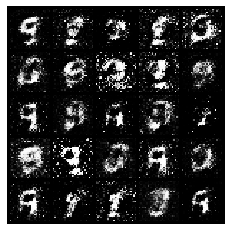

Epoch 2/20 ==> loss: 1.7735503799191776, gen_loss: 1.1972372580380937, disc_loss: 0.576313121881084


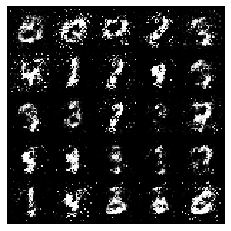

Epoch 3/20 ==> loss: 1.7907299915332027, gen_loss: 1.213751065774635, disc_loss: 0.5769789257585676


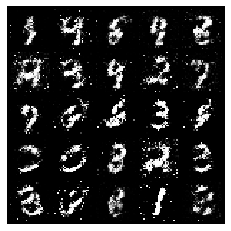

Epoch 4/20 ==> loss: 1.6685128898463693, gen_loss: 1.057360243099917, disc_loss: 0.6111526467464524


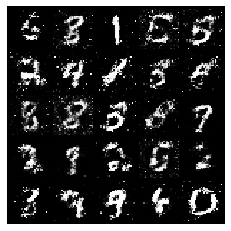

Epoch 5/20 ==> loss: 1.60222713363236, gen_loss: 0.9672455554470502, disc_loss: 0.6349815781853099


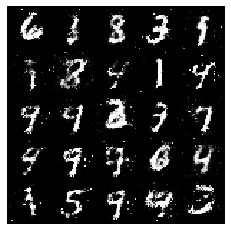

Epoch 6/20 ==> loss: 1.582781653517561, gen_loss: 0.9403986953730121, disc_loss: 0.6423829581445488


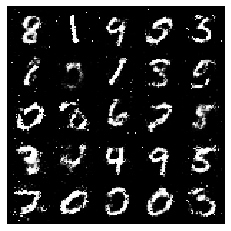

Epoch 7/20 ==> loss: 1.564498584765185, gen_loss: 0.9134823076794745, disc_loss: 0.6510162770857105


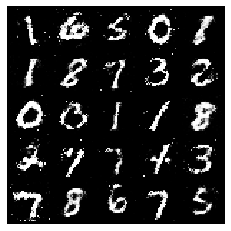

Epoch 8/20 ==> loss: 1.5601714970424798, gen_loss: 0.9036697341057675, disc_loss: 0.6565017629367124


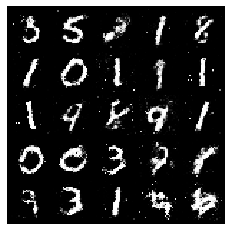

Epoch 9/20 ==> loss: 1.5526261368878798, gen_loss: 0.8928085949128899, disc_loss: 0.65981754197499


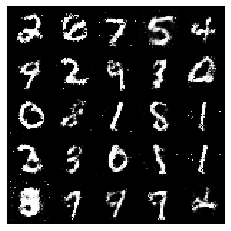

Epoch 10/20 ==> loss: 1.55218489557995, gen_loss: 0.8897588992903394, disc_loss: 0.6624259962896106


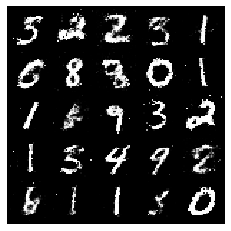

Epoch 11/20 ==> loss: 1.5453309810139797, gen_loss: 0.8801159578659853, disc_loss: 0.6652150231479944


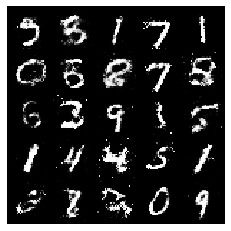

Epoch 12/20 ==> loss: 1.5425666649119292, gen_loss: 0.8749480653942394, disc_loss: 0.6676185995176898


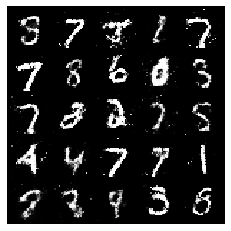

Epoch 13/20 ==> loss: 1.5366681944953458, gen_loss: 0.8673095651910772, disc_loss: 0.6693586293042687


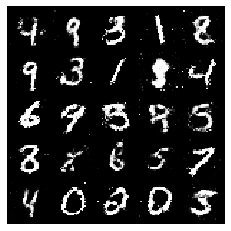

Epoch 14/20 ==> loss: 1.529083143749446, gen_loss: 0.8584057739927302, disc_loss: 0.670677369756716


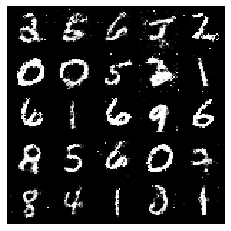

Epoch 15/20 ==> loss: 1.5262253859797168, gen_loss: 0.8532505497418112, disc_loss: 0.6729748362379057


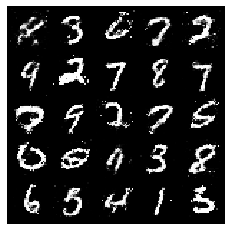

Epoch 16/20 ==> loss: 1.5213870375095382, gen_loss: 0.8474719033489716, disc_loss: 0.6739151341605666


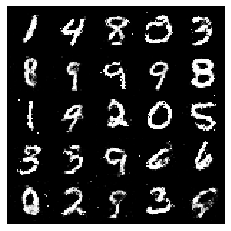

Epoch 17/20 ==> loss: 1.518637215415564, gen_loss: 0.8436656717408509, disc_loss: 0.6749715436747131


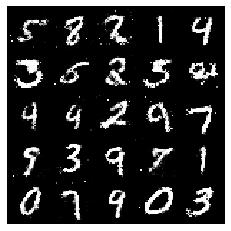

Epoch 18/20 ==> loss: 1.5127169365638788, gen_loss: 0.8363036079642105, disc_loss: 0.6764133285996683


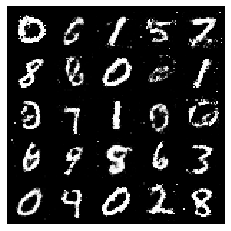

Epoch 19/20 ==> loss: 1.511132090248617, gen_loss: 0.8344575565519455, disc_loss: 0.6766745336966715


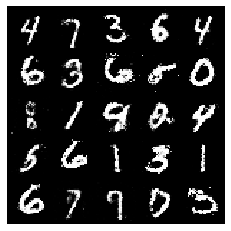

Epoch 20/20 ==> loss: 1.5051823876239698, gen_loss: 0.827243291154858, disc_loss: 0.677939096469112


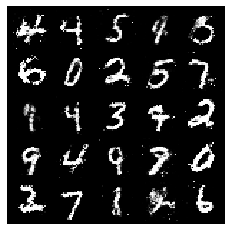

In [5]:
gen_losses, disc_losses = train_loop(
    generator, 
    discriminator,
    dataloader,
    optimizer_G,
    optimizer_D,
    bce_loss,
    20,
    False,
    use_wasserstein=False
)

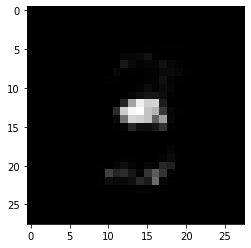

In [6]:
z = torch.randn((2, 100)).to(device)

# Generate a batch of images
with torch.no_grad():
    gen_imgs = generator(z, None)
    
plt.imshow(gen_imgs.cpu().numpy()[0].reshape((28, 28)), cmap='gray')

In [7]:
class Classifer(nn.Module):
    def __init__(self, in_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(in_dims, 16, kernel_size=(3, 3), padding=1, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, stride=2)
        self.dense1 = nn.Linear(4 * 4 * 64, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        x = x.view(-1, 4 * 4 * 64)
        x = self.dense1(x)
        x = torch.softmax(x, dim=1)
        return x
    
clf = Classifer(1).to(device)

clf_optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)


for epoch in range(1, 11):
    running_loss = 0
    running_accuracy = 0
    iterations = 0
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        clf_optim.zero_grad()
        y_pred = clf(x)
        loss = criterion(y_pred, y)
        loss.backward()
        clf_optim.step()
        running_loss += loss.item()
        iterations += 1
        with torch.no_grad():
            accuracy = torch.mean(((torch.argmax(y_pred, 1) == y) * 1).float())
            running_accuracy += accuracy.item()
    loss = running_loss / iterations
    acc = running_accuracy / iterations
    print(f"Epoch {epoch}/10 ==> train loss: {loss}, train acc: {acc}")

Epoch 1/10 ==> train loss: 1.6626333401451598, train acc: 0.8058545803021251
Epoch 2/10 ==> train loss: 1.5270426648190514, train acc: 0.9361839743375342
Epoch 3/10 ==> train loss: 1.489318936572868, train acc: 0.973408119007264
Epoch 4/10 ==> train loss: 1.484337958600883, train acc: 0.9777581452015767
Epoch 5/10 ==> train loss: 1.4803517573058496, train acc: 0.9815470749542962
Epoch 6/10 ==> train loss: 1.4784648547006918, train acc: 0.9831569111979204
Epoch 7/10 ==> train loss: 1.4766309681932495, train acc: 0.9847993929163847
Epoch 8/10 ==> train loss: 1.4749631827230645, train acc: 0.9866989587299131
Epoch 9/10 ==> train loss: 1.4740353580802625, train acc: 0.9873743144424132
Epoch 10/10 ==> train loss: 1.4726781439737602, train acc: 0.9889270208871342


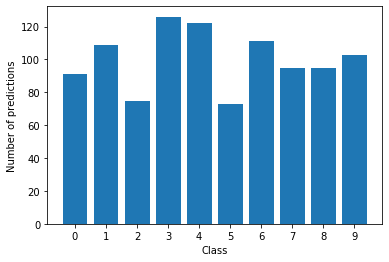

In [8]:
z = torch.randn((1000, latent_dim)).to(device)

# Generate a batch of images
with torch.no_grad():
    gen_imgs = generator(z)
    y_pred = clf(gen_imgs)
    
y_pred = np.argmax(y_pred.cpu().numpy(), axis=1)
plot_class_distributions(y_pred, 10)

# WGAN

In [9]:
def wasserstein_loss(y_pred):
    return torch.mean(y_pred)


# Optimizers
# It's recommended to use RMSProp for WGAN

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator(0, use_sigmoid=False)

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.00005)

generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Epoch 1/200 ==> loss: -21.464939512889593, gen_loss: -8.235167926226758, disc_loss: -13.229771586662835


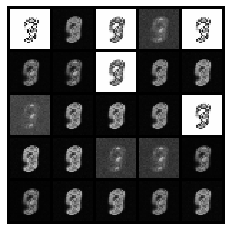

Epoch 2/200 ==> loss: -26.645569231218133, gen_loss: -15.980255149618145, disc_loss: -10.665314081599988


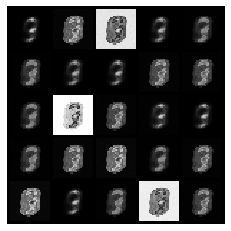

Epoch 3/200 ==> loss: -25.754377466233166, gen_loss: -17.177097210718465, disc_loss: -8.5772802555147


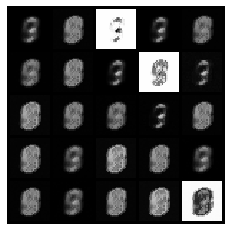

Epoch 4/200 ==> loss: -25.49296621779419, gen_loss: -18.731292222492, disc_loss: -6.76167399530219


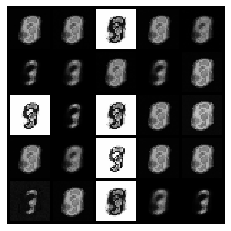

Epoch 5/200 ==> loss: -24.26027668633888, gen_loss: -19.04906012763489, disc_loss: -5.211216558703993


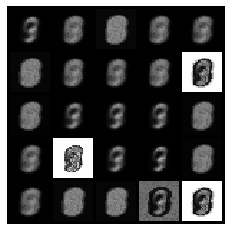

Epoch 6/200 ==> loss: -22.796223882783263, gen_loss: -19.056568215490476, disc_loss: -3.7396556672927885


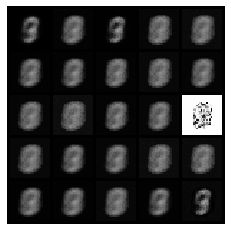

Epoch 7/200 ==> loss: -20.462189400653735, gen_loss: -18.574004607401122, disc_loss: -1.8881847932526137


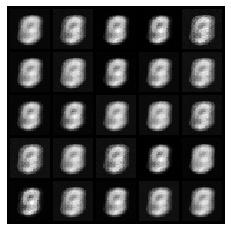

Epoch 8/200 ==> loss: -17.180650611682175, gen_loss: -16.497169278439483, disc_loss: -0.6834813332426919


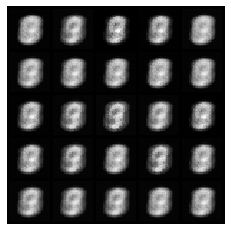

Epoch 9/200 ==> loss: -14.38014437555177, gen_loss: -14.074943694161759, disc_loss: -0.30520068139001266


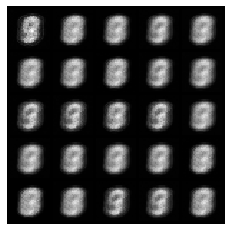

Epoch 10/200 ==> loss: -13.102222902901213, gen_loss: -12.946840451883878, disc_loss: -0.15538245101733444


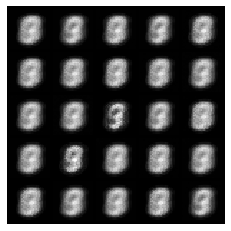

Epoch 11/200 ==> loss: -13.260886493940895, gen_loss: -13.183400992719521, disc_loss: -0.07748550122137261


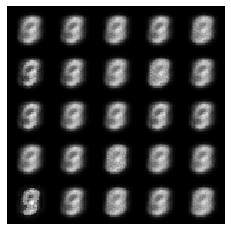

Epoch 12/200 ==> loss: -12.794367753609443, gen_loss: -12.748572841204934, disc_loss: -0.045794912404508434


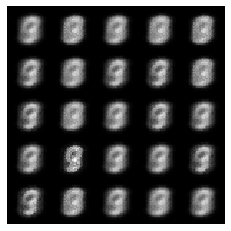

Epoch 13/200 ==> loss: -11.63463008469158, gen_loss: -11.611533147543396, disc_loss: -0.023096937148183092


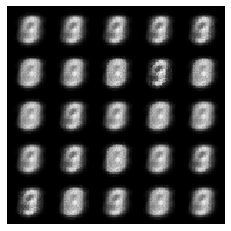

Epoch 14/200 ==> loss: -11.400801370958959, gen_loss: -11.389229919182535, disc_loss: -0.011571451776424317


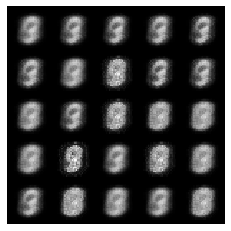

Epoch 15/200 ==> loss: -9.829872361484787, gen_loss: -9.82150563374298, disc_loss: -0.008366727741806338


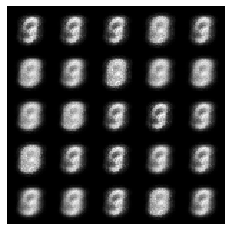

Epoch 16/200 ==> loss: -8.371068939648337, gen_loss: -8.36698927173231, disc_loss: -0.004079667916027676


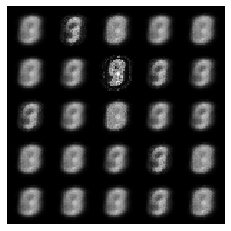

Epoch 17/200 ==> loss: -3.1967333749181828, gen_loss: -3.1925924404011785, disc_loss: -0.004140934517004372


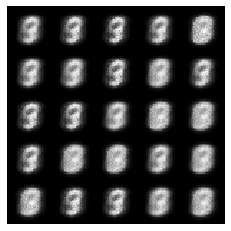

Epoch 18/200 ==> loss: -2.2903184356811495, gen_loss: -2.284710713888653, disc_loss: -0.005607721792496537


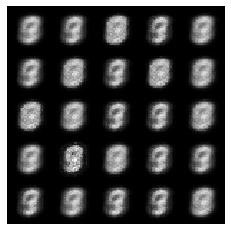

Epoch 19/200 ==> loss: -2.0284354083062963, gen_loss: -1.9893039558661703, disc_loss: -0.03913145244012585


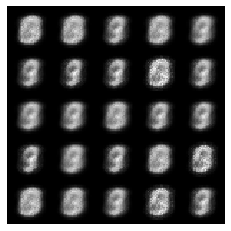

Epoch 20/200 ==> loss: -2.2896582988759935, gen_loss: -2.2443695499866494, disc_loss: -0.04528874888934427


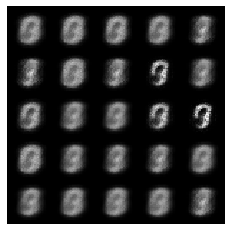

Epoch 21/200 ==> loss: -2.7610850595686944, gen_loss: -2.713748471174641, disc_loss: -0.047336588394053455


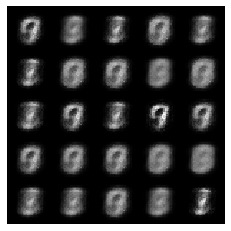

Epoch 22/200 ==> loss: -3.173040804087135, gen_loss: -3.124305124474618, disc_loss: -0.04873567961251714


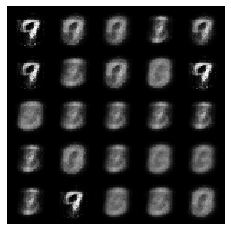

Epoch 23/200 ==> loss: -2.826023624409705, gen_loss: -2.7802049106828037, disc_loss: -0.04581871372690149


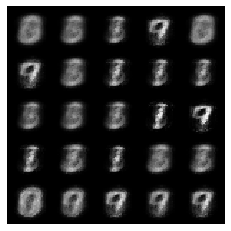

Epoch 24/200 ==> loss: -2.3749358405578724, gen_loss: -2.3223768477030164, disc_loss: -0.05255899285485583


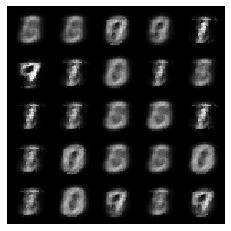

Epoch 25/200 ==> loss: -2.095646572069451, gen_loss: -2.0248419846215677, disc_loss: -0.07080458744788301


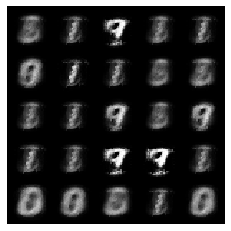

Epoch 26/200 ==> loss: -2.0855615261049985, gen_loss: -1.998438601955853, disc_loss: -0.08712292414914537


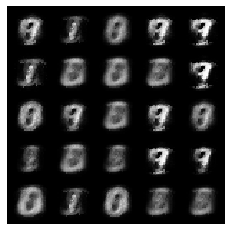

Epoch 27/200 ==> loss: -1.9262032643968487, gen_loss: -1.8305283780507675, disc_loss: -0.09567488634608128


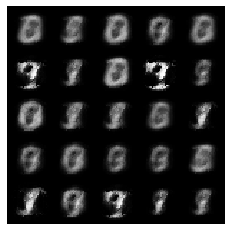

Epoch 28/200 ==> loss: -2.084552602096711, gen_loss: -1.986370806066384, disc_loss: -0.09818179603032699


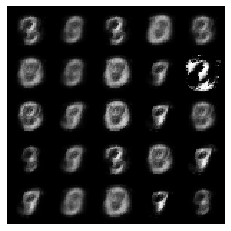

Epoch 29/200 ==> loss: -2.283414476532387, gen_loss: -2.183201842377783, disc_loss: -0.10021263415460395


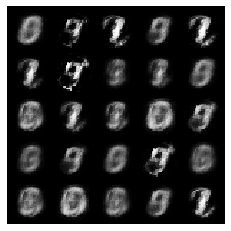

Epoch 30/200 ==> loss: -2.2017775390440195, gen_loss: -2.092578553194538, disc_loss: -0.10919898584948161


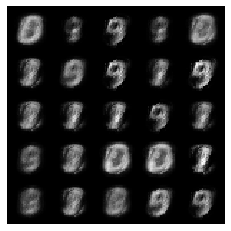

Epoch 31/200 ==> loss: -2.2419127086398807, gen_loss: -2.1307573780499167, disc_loss: -0.11115533058996392


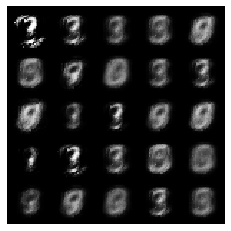

Epoch 32/200 ==> loss: -2.2837184277487412, gen_loss: -2.181422945132421, disc_loss: -0.10229548261631995


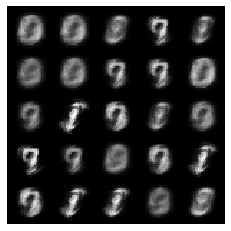

Epoch 33/200 ==> loss: -1.7337604301285263, gen_loss: -1.622499310338301, disc_loss: -0.1112611197902254


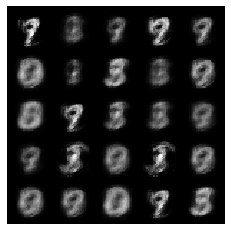

Epoch 34/200 ==> loss: -1.4275352943967856, gen_loss: -1.3065710337985803, disc_loss: -0.12096426059820534


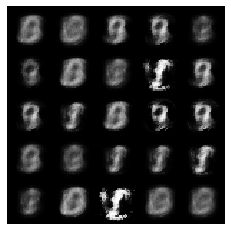

Epoch 35/200 ==> loss: -1.5704449504559395, gen_loss: -1.4379772122207028, disc_loss: -0.13246773823523653


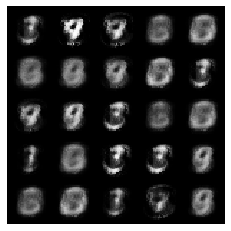

Epoch 36/200 ==> loss: -1.819759635428406, gen_loss: -1.6685336244171673, disc_loss: -0.15122601101123873


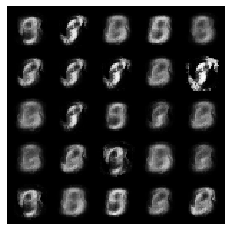

Epoch 37/200 ==> loss: -2.038076835097081, gen_loss: -1.8728868069988718, disc_loss: -0.16519002809820924


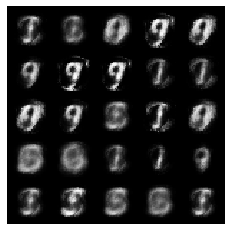

Epoch 38/200 ==> loss: -2.4213938723970374, gen_loss: -2.256841177260418, disc_loss: -0.16455269513661944


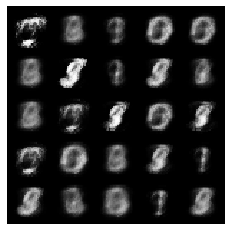

Epoch 39/200 ==> loss: -1.9856585283819892, gen_loss: -1.8127608600002756, disc_loss: -0.17289766838171364


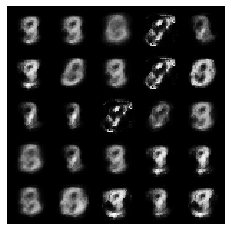

Epoch 40/200 ==> loss: -1.938052655138089, gen_loss: -1.7905810731420568, disc_loss: -0.14747158199603205


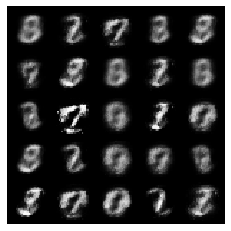

Epoch 41/200 ==> loss: -2.3104044628317655, gen_loss: -2.1297007162784527, disc_loss: -0.18070374655331292


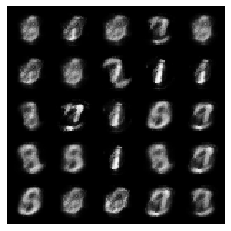

Epoch 42/200 ==> loss: -2.535604944830621, gen_loss: -2.372904466754558, disc_loss: -0.16270047807606308


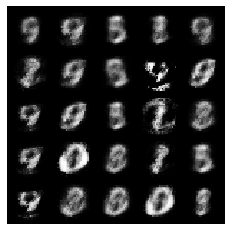

Epoch 43/200 ==> loss: -2.1722854840036283, gen_loss: -1.9804799177528953, disc_loss: -0.19180556625073308


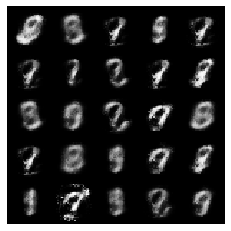

Epoch 44/200 ==> loss: -2.4885305373280753, gen_loss: -2.3203604393510977, disc_loss: -0.16817009797697746


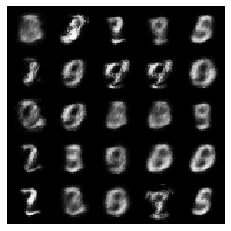

Epoch 45/200 ==> loss: -2.5059697843774797, gen_loss: -2.32261022876342, disc_loss: -0.18335955561405998


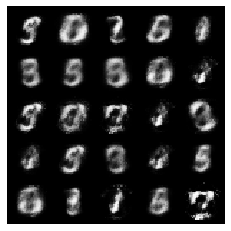

Epoch 46/200 ==> loss: -2.311681861851289, gen_loss: -2.156153277243731, disc_loss: -0.15552858460755845


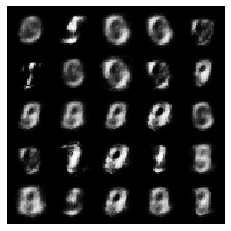

Epoch 47/200 ==> loss: -2.7135607845386596, gen_loss: -2.5475201465094113, disc_loss: -0.16604063802924846


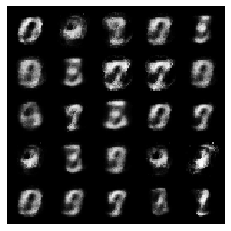

Epoch 48/200 ==> loss: -2.2631864737331107, gen_loss: -2.08737837963174, disc_loss: -0.17580809410137058


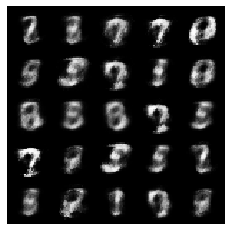

Epoch 49/200 ==> loss: -2.0855740840517845, gen_loss: -1.9358690436622996, disc_loss: -0.14970504038948462


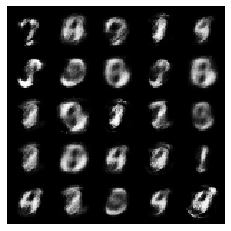

Epoch 50/200 ==> loss: -1.8822211975153447, gen_loss: -1.7348120637524063, disc_loss: -0.14740913376293846


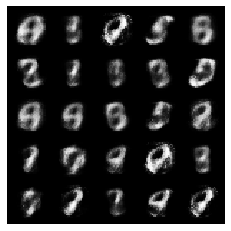

Epoch 51/200 ==> loss: -2.3284962911710445, gen_loss: -2.169375377773585, disc_loss: -0.15912091339745948


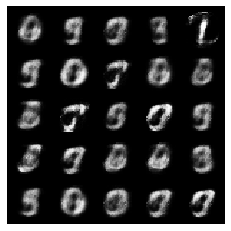

Epoch 52/200 ==> loss: -2.0711502128806805, gen_loss: -1.9210496554644931, disc_loss: -0.15010055741618714


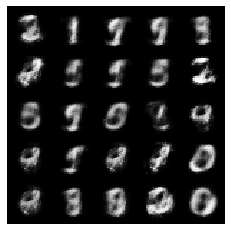

Epoch 53/200 ==> loss: -1.834713722059888, gen_loss: -1.6869318343603632, disc_loss: -0.14778188769952472


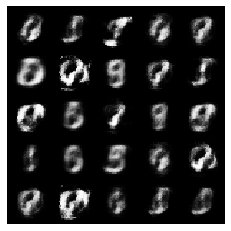

Epoch 54/200 ==> loss: -1.779271710071529, gen_loss: -1.6275407258945584, disc_loss: -0.15173098417697048


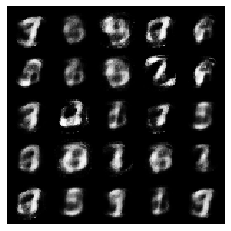

Epoch 55/200 ==> loss: -1.7525789630914301, gen_loss: -1.6137951331339109, disc_loss: -0.1387838299575192


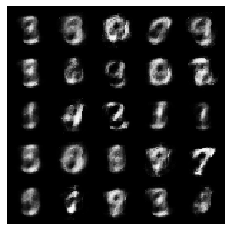

Epoch 56/200 ==> loss: -1.738941966942503, gen_loss: -1.5979184332887695, disc_loss: -0.1410235336537335


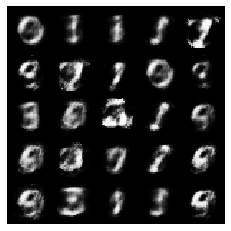

Epoch 57/200 ==> loss: -1.6015031727837905, gen_loss: -1.4573500823277223, disc_loss: -0.1441530904560682


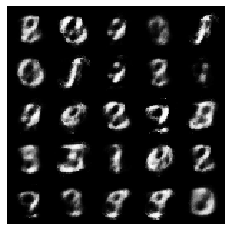

Epoch 58/200 ==> loss: -1.5839330073466467, gen_loss: -1.4348505759369956, disc_loss: -0.149082431409651


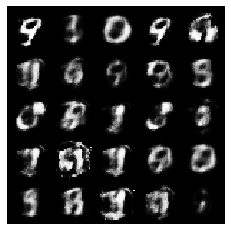

Epoch 59/200 ==> loss: -1.4048071370700161, gen_loss: -1.2562035944387726, disc_loss: -0.14860354263124345


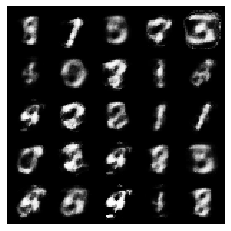

Epoch 60/200 ==> loss: -1.4073287026319905, gen_loss: -1.2547513558180283, disc_loss: -0.15257734681396207


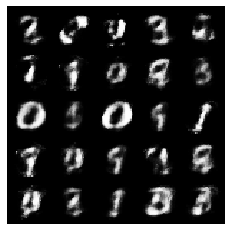

Epoch 61/200 ==> loss: -1.286692659968214, gen_loss: -1.1324426734469273, disc_loss: -0.15424998652128677


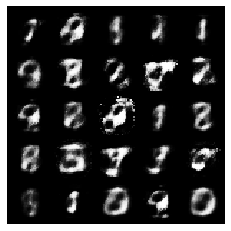

Epoch 62/200 ==> loss: -1.188255860775001, gen_loss: -1.033297677144708, disc_loss: -0.15495818363029298


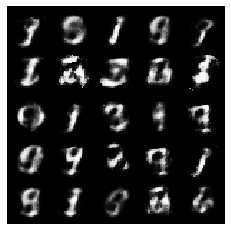

Epoch 63/200 ==> loss: -1.0011165808933962, gen_loss: -0.8436154403895739, disc_loss: -0.15750114050382233


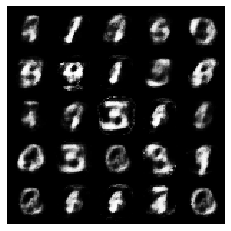

Epoch 64/200 ==> loss: -1.0292074449319508, gen_loss: -0.8672286793998216, disc_loss: -0.1619787655321292


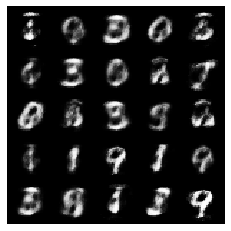

Epoch 65/200 ==> loss: -1.0693345449088478, gen_loss: -0.9073204255409171, disc_loss: -0.16201411936793075


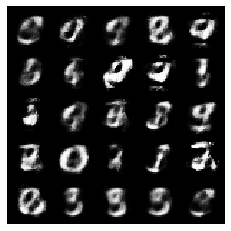

Epoch 66/200 ==> loss: -1.3007608644487219, gen_loss: -1.138444041857118, disc_loss: -0.1623168225916038


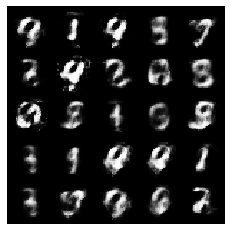

Epoch 67/200 ==> loss: -1.0460866819352075, gen_loss: -0.8749690515685561, disc_loss: -0.1711176303666514


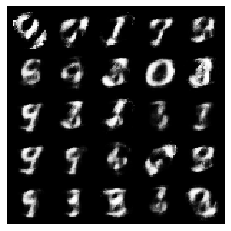

Epoch 68/200 ==> loss: -1.2122694742091178, gen_loss: -1.0371179136105386, disc_loss: -0.17515156059857914


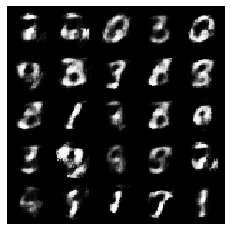

Epoch 69/200 ==> loss: -1.2608086419933673, gen_loss: -1.0903929658302223, disc_loss: -0.17041567616314512


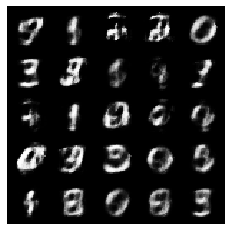

Epoch 70/200 ==> loss: -0.844330880879484, gen_loss: -0.6792053176563444, disc_loss: -0.16512556322313968


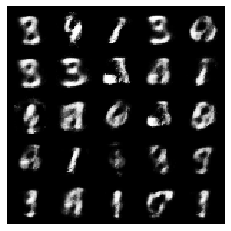

Epoch 71/200 ==> loss: -1.122439733262036, gen_loss: -0.9463632992678194, disc_loss: -0.1760764339942165


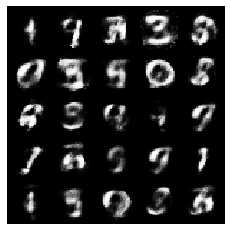

Epoch 72/200 ==> loss: -0.9959860683795085, gen_loss: -0.8242973520725257, disc_loss: -0.1716887163069828


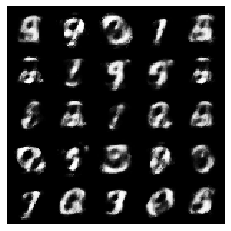

Epoch 73/200 ==> loss: -1.1293661757840534, gen_loss: -0.9542796293603872, disc_loss: -0.17508654642366622


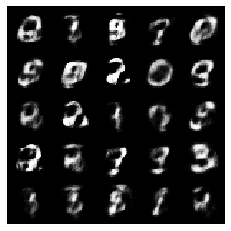

Epoch 74/200 ==> loss: -1.094943667678554, gen_loss: -0.9318675196149013, disc_loss: -0.1630761480636527


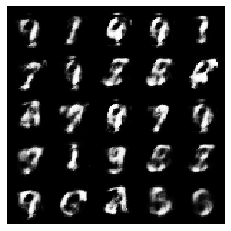

Epoch 75/200 ==> loss: -1.110058293373101, gen_loss: -0.9450733297703688, disc_loss: -0.16498496360273204


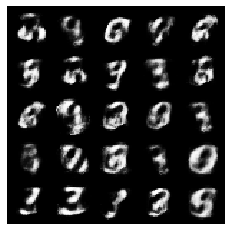

Epoch 76/200 ==> loss: -1.1440173973766934, gen_loss: -0.9797938278649799, disc_loss: -0.16422356951171346


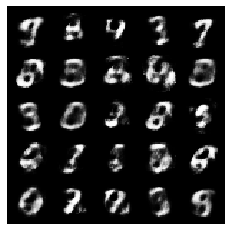

Epoch 77/200 ==> loss: -1.0882875361433848, gen_loss: -0.923010430889548, disc_loss: -0.1652771052538368


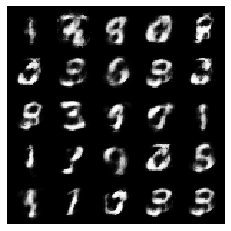

Epoch 78/200 ==> loss: -0.9225650400304708, gen_loss: -0.7578150193041814, disc_loss: -0.16475002072628936


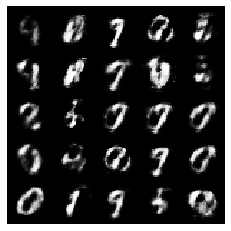

Epoch 79/200 ==> loss: -0.8209857445421341, gen_loss: -0.653185490443894, disc_loss: -0.16780025409824015


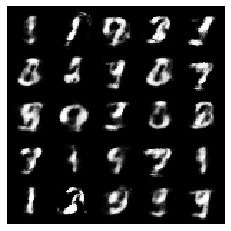

Epoch 80/200 ==> loss: -0.8456969687228229, gen_loss: -0.6834012787564363, disc_loss: -0.1622956899663866


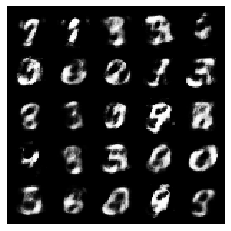

Epoch 81/200 ==> loss: -0.8257702082885903, gen_loss: -0.6655783341615248, disc_loss: -0.16019187412706545


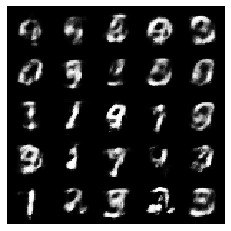

Epoch 82/200 ==> loss: -0.7597012568871326, gen_loss: -0.6004230471590102, disc_loss: -0.1592782097281224


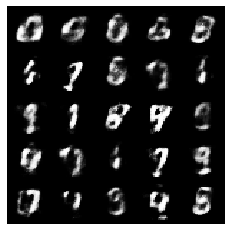

Epoch 83/200 ==> loss: -0.7888984541788397, gen_loss: -0.6337219959966007, disc_loss: -0.15517645818223902


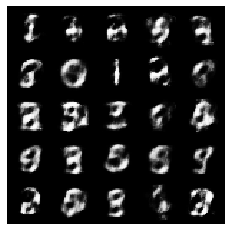

Epoch 84/200 ==> loss: -0.7719703519910955, gen_loss: -0.6167871636054197, disc_loss: -0.15518318838567577


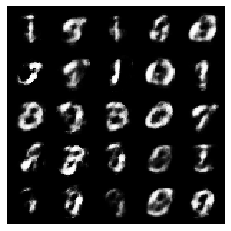

Epoch 85/200 ==> loss: -0.8678154885441991, gen_loss: -0.7152807026066336, disc_loss: -0.15253478593756556


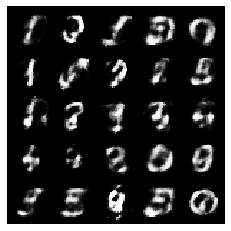

Epoch 86/200 ==> loss: -0.8058050557072027, gen_loss: -0.6578371783061263, disc_loss: -0.14796787740107648


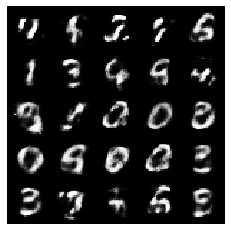

Epoch 87/200 ==> loss: -0.6552133833686439, gen_loss: -0.5061469063353495, disc_loss: -0.14906647703329431


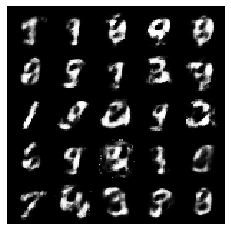

Epoch 88/200 ==> loss: -0.7434775730700554, gen_loss: -0.5937439167303402, disc_loss: -0.14973365633971514


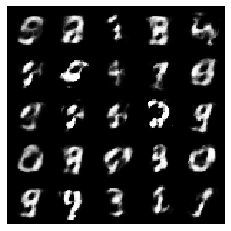

Epoch 89/200 ==> loss: -0.8008368179283805, gen_loss: -0.6555337887359494, disc_loss: -0.1453030291924311


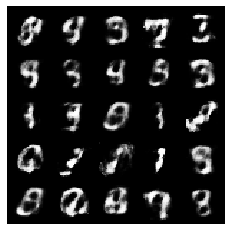

Epoch 90/200 ==> loss: -0.7705154613450415, gen_loss: -0.6257887496808765, disc_loss: -0.14472671166416495


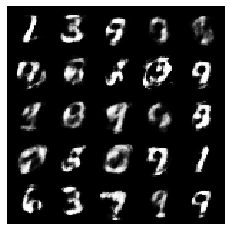

Epoch 91/200 ==> loss: -0.800794288979152, gen_loss: -0.6555243474473901, disc_loss: -0.1452699415317619


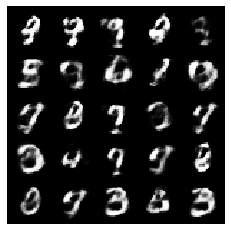

Epoch 92/200 ==> loss: -0.8382131187092016, gen_loss: -0.6961730640156831, disc_loss: -0.14204005469351844


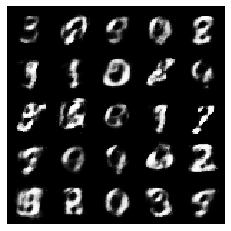

Epoch 93/200 ==> loss: -0.8131886680339765, gen_loss: -0.6691618064857706, disc_loss: -0.14402686154820585


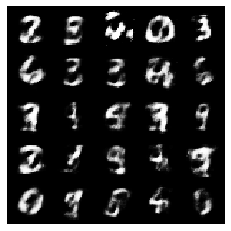

Epoch 94/200 ==> loss: -0.7500324473738453, gen_loss: -0.611554098848451, disc_loss: -0.13847834852539426


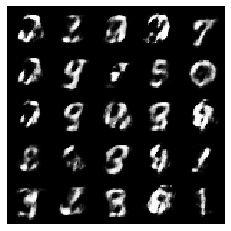

Epoch 95/200 ==> loss: -0.4218524295804338, gen_loss: -0.2521236559224589, disc_loss: -0.16972877365797487


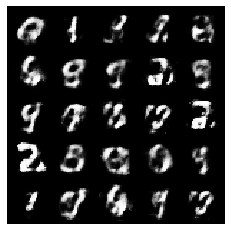

Epoch 96/200 ==> loss: -0.20863165605389317, gen_loss: 0.021672754923487848, disc_loss: -0.23030441097738102


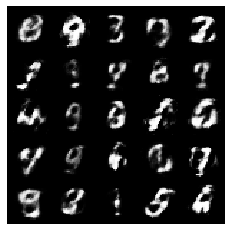

Epoch 97/200 ==> loss: -0.46278015791797766, gen_loss: -0.22083752355121172, disc_loss: -0.24194263436676597


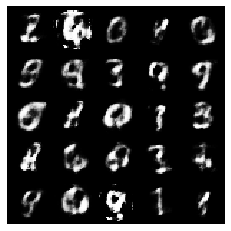

Epoch 98/200 ==> loss: -0.7059568644278228, gen_loss: -0.46302664451559894, disc_loss: -0.24293021991222388


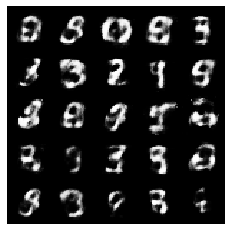

Epoch 99/200 ==> loss: -0.9613689895194888, gen_loss: -0.7227223188066395, disc_loss: -0.23864667071284934


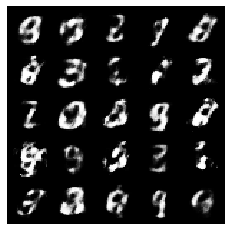

Epoch 100/200 ==> loss: -1.160948936856425, gen_loss: -0.9192193977575633, disc_loss: -0.24172953909886166


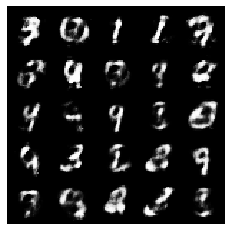

Epoch 101/200 ==> loss: -1.1129647065669135, gen_loss: -0.8604671884280454, disc_loss: -0.25249751813886806


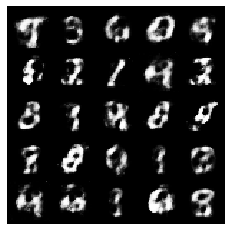

Epoch 102/200 ==> loss: -1.2028059836279539, gen_loss: -0.9524200033444156, disc_loss: -0.2503859802835384


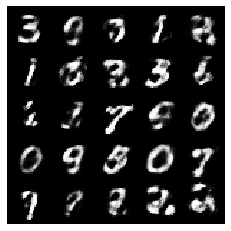

Epoch 103/200 ==> loss: -1.2366442144243983, gen_loss: -0.9953463559176847, disc_loss: -0.24129785850671354


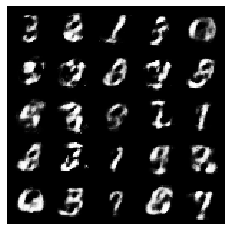

Epoch 104/200 ==> loss: -0.9954222399312356, gen_loss: -0.7590071309964007, disc_loss: -0.23641510893483483


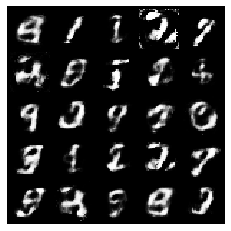

Epoch 105/200 ==> loss: -1.0442818605921604, gen_loss: -0.8093288304382966, disc_loss: -0.23495303015386382


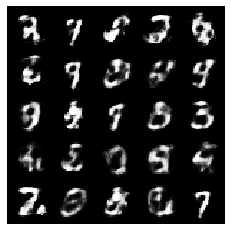

Epoch 106/200 ==> loss: -1.0316207923226643, gen_loss: -0.7981760172238079, disc_loss: -0.23344477509885644


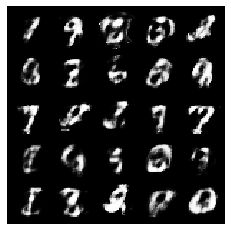

Epoch 107/200 ==> loss: -0.9301752916637679, gen_loss: -0.692134312781381, disc_loss: -0.23804097888238687


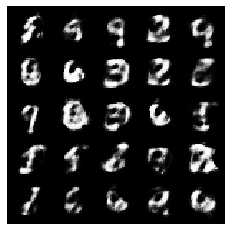

Epoch 108/200 ==> loss: -0.787808614958357, gen_loss: -0.5550585810837406, disc_loss: -0.23275003387461632


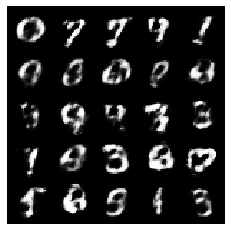

Epoch 109/200 ==> loss: -0.6332640934844502, gen_loss: -0.39989613327223267, disc_loss: -0.23336796021221762


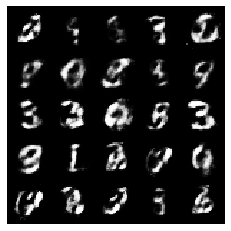

Epoch 110/200 ==> loss: -0.8380628727798706, gen_loss: -0.6073654414421897, disc_loss: -0.23069743133768086


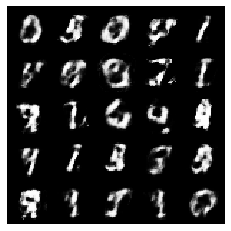

Epoch 111/200 ==> loss: -0.6876212575045538, gen_loss: -0.4586610986393156, disc_loss: -0.22896015886523824


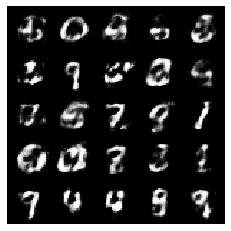

Epoch 112/200 ==> loss: -0.7510512583434473, gen_loss: -0.5306339671995348, disc_loss: -0.2204172911439125


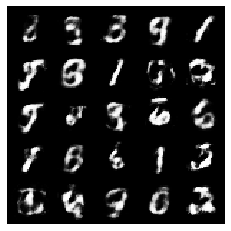

Epoch 113/200 ==> loss: -0.561145928267805, gen_loss: -0.3413838219762502, disc_loss: -0.21976210629155474


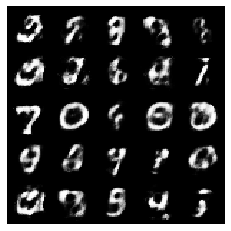

Epoch 114/200 ==> loss: -0.6165978911399188, gen_loss: -0.3983411435480528, disc_loss: -0.218256747591866


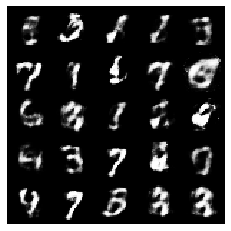

Epoch 115/200 ==> loss: -0.6409781681172808, gen_loss: -0.4258085829248376, disc_loss: -0.21516958519244325


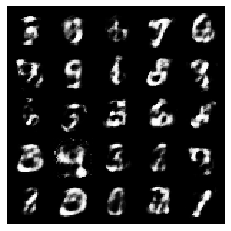

Epoch 116/200 ==> loss: -0.7325111735455515, gen_loss: -0.5154168974655856, disc_loss: -0.2170942760799659


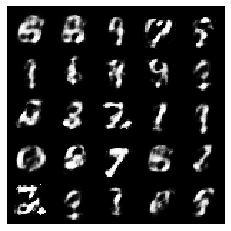

Epoch 117/200 ==> loss: -0.7889794979169555, gen_loss: -0.5704163655611453, disc_loss: -0.2185631323558103


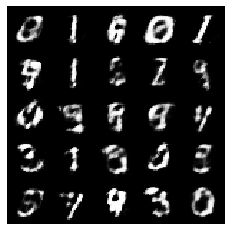

Epoch 118/200 ==> loss: -0.8517662355407283, gen_loss: -0.6384599895320383, disc_loss: -0.21330624600868991


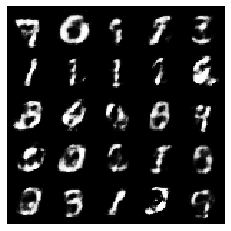

Epoch 119/200 ==> loss: -0.7448981312500276, gen_loss: -0.5313389595237031, disc_loss: -0.21355917172632444


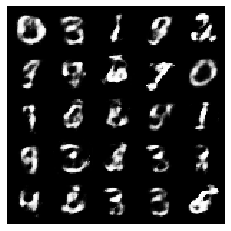

Epoch 120/200 ==> loss: -0.7480531918937152, gen_loss: -0.5375887338596462, disc_loss: -0.21046445803406905


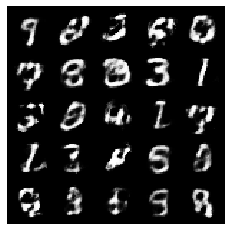

Epoch 121/200 ==> loss: -0.8069470246923471, gen_loss: -0.604056387976275, disc_loss: -0.20289063671607205


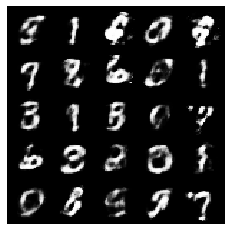

Epoch 122/200 ==> loss: -0.797317581867605, gen_loss: -0.5930303538957069, disc_loss: -0.20428722797189813


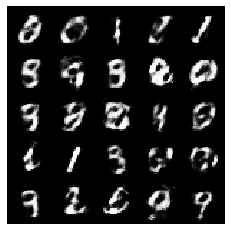

Epoch 123/200 ==> loss: -0.823239131862982, gen_loss: -0.6201373207939608, disc_loss: -0.20310181106902128


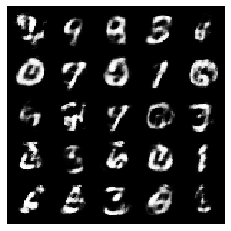

Epoch 124/200 ==> loss: -0.8295702401419226, gen_loss: -0.6296106574740227, disc_loss: -0.19995958266789995


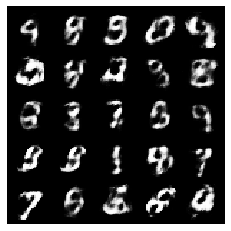

Epoch 125/200 ==> loss: -0.8957595425288464, gen_loss: -0.6916099979084196, disc_loss: -0.20414954462042675


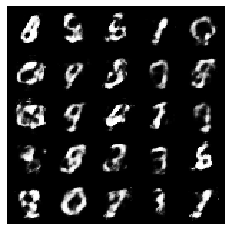

Epoch 126/200 ==> loss: -0.8654711464968199, gen_loss: -0.665956254197213, disc_loss: -0.19951489229960678


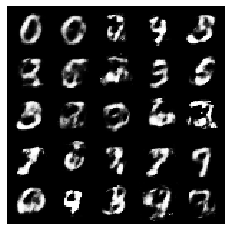

Epoch 127/200 ==> loss: -0.8991582596868658, gen_loss: -0.7099539235479435, disc_loss: -0.1892043361389223


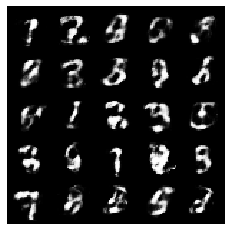

Epoch 128/200 ==> loss: -0.9381325335345713, gen_loss: -0.747302909328907, disc_loss: -0.19082962420566427


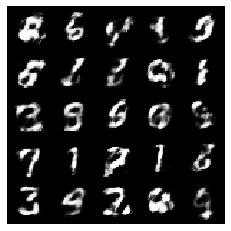

Epoch 129/200 ==> loss: -0.8248328006463688, gen_loss: -0.6369340096138949, disc_loss: -0.18789879103247384


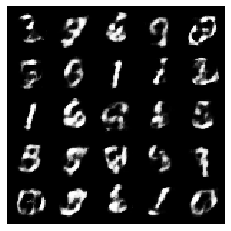

Epoch 130/200 ==> loss: -0.7195380560549782, gen_loss: -0.5316548898298518, disc_loss: -0.1878831662251265


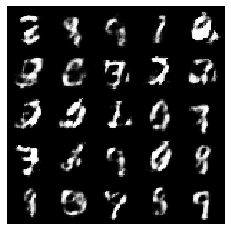

Epoch 131/200 ==> loss: -0.8630433662282048, gen_loss: -0.6751090234223842, disc_loss: -0.18793434280582058


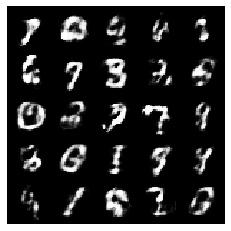

Epoch 132/200 ==> loss: -0.8911865430405632, gen_loss: -0.7028103114482036, disc_loss: -0.18837623159235967


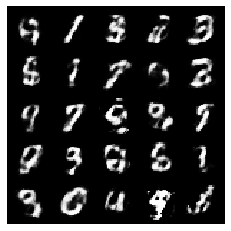

Epoch 133/200 ==> loss: -0.93811212172238, gen_loss: -0.7533455668681283, disc_loss: -0.18476655485425178


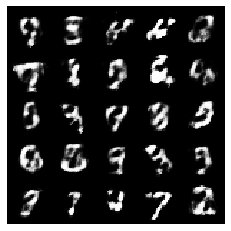

Epoch 134/200 ==> loss: -0.8812986770321289, gen_loss: -0.6965199173368527, disc_loss: -0.18477875969527627


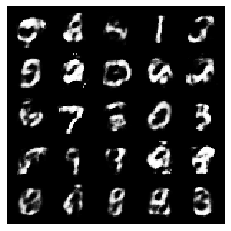

Epoch 135/200 ==> loss: -0.8937484829582723, gen_loss: -0.7107071482612184, disc_loss: -0.1830413346970539


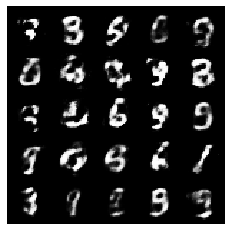

Epoch 136/200 ==> loss: -0.8367088208250851, gen_loss: -0.656548801516702, disc_loss: -0.1801600193083831


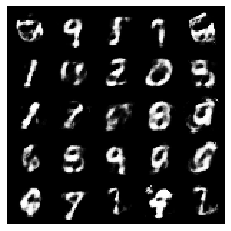

Epoch 137/200 ==> loss: -0.9848112627400777, gen_loss: -0.8060035596599963, disc_loss: -0.17880770308008143


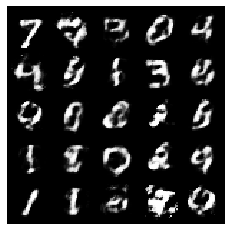

Epoch 138/200 ==> loss: -0.9195474980082329, gen_loss: -0.7438485038345867, disc_loss: -0.17569899417364618


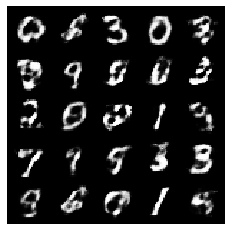

Epoch 139/200 ==> loss: -0.9108942646866961, gen_loss: -0.7373451291425137, disc_loss: -0.1735491355441824


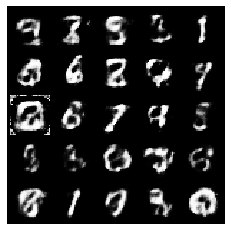

Epoch 140/200 ==> loss: -0.9641087383740127, gen_loss: -0.7895727809756939, disc_loss: -0.17453595739831873


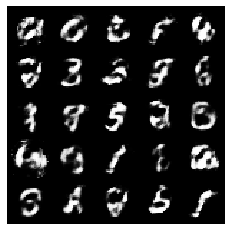

Epoch 141/200 ==> loss: -0.9845586925799494, gen_loss: -0.8142034325346869, disc_loss: -0.17035526004526252


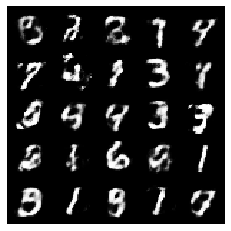

Epoch 142/200 ==> loss: -0.9189439390324587, gen_loss: -0.7479617397898511, disc_loss: -0.17098219924260755


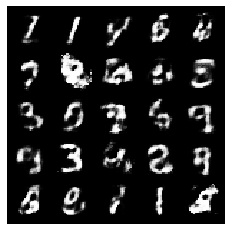

Epoch 143/200 ==> loss: -0.8728715944115815, gen_loss: -0.701241947015853, disc_loss: -0.1716296473957285


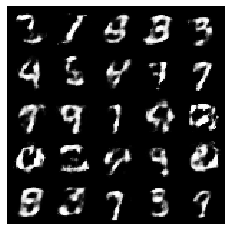

Epoch 144/200 ==> loss: -1.0267789054396383, gen_loss: -0.8587794650407334, disc_loss: -0.1679994403989049


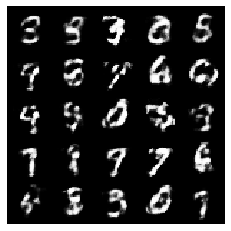

Epoch 145/200 ==> loss: -0.9663886243726043, gen_loss: -0.798137633412586, disc_loss: -0.1682509909600183


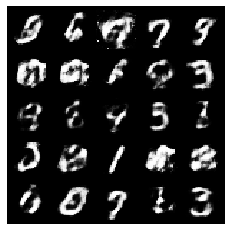

Epoch 146/200 ==> loss: -1.0813965951067002, gen_loss: -0.9142412301391308, disc_loss: -0.16715536496756936


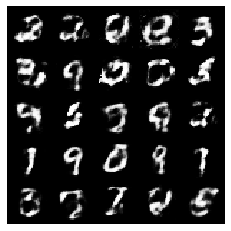

Epoch 147/200 ==> loss: -1.039615348117661, gen_loss: -0.8781341331750427, disc_loss: -0.1614812149426183


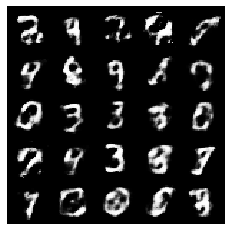

Epoch 148/200 ==> loss: -0.9598697086138961, gen_loss: -0.7967340282591867, disc_loss: -0.16313568035470938


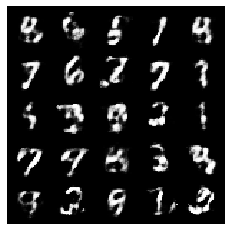

Epoch 149/200 ==> loss: -0.9467002631759295, gen_loss: -0.7848604682158726, disc_loss: -0.16183979496005685


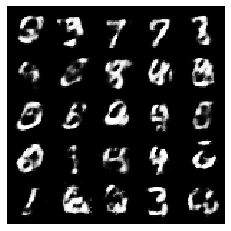

Epoch 150/200 ==> loss: -1.1087432666060257, gen_loss: -0.9503773103248485, disc_loss: -0.1583659562811773


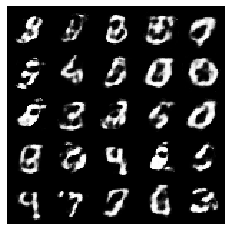

Epoch 151/200 ==> loss: -1.1072483740515422, gen_loss: -0.9503973207046607, disc_loss: -0.15685105334688149


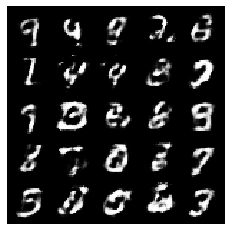

Epoch 152/200 ==> loss: -0.9985180806634195, gen_loss: -0.8392902865488306, disc_loss: -0.15922779411458882


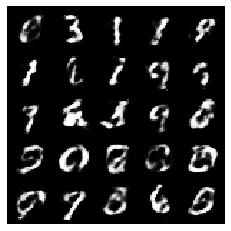

Epoch 153/200 ==> loss: -1.0702331654550388, gen_loss: -0.9140909559330077, disc_loss: -0.15614220952203112


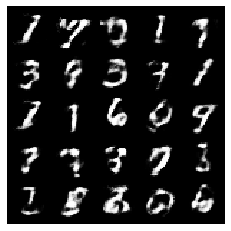

Epoch 154/200 ==> loss: -1.0485289130611872, gen_loss: -0.8959954378809746, disc_loss: -0.1525334751802127


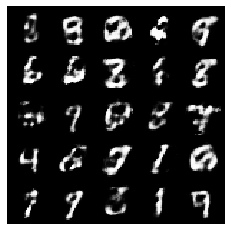

Epoch 155/200 ==> loss: -1.0811649490100157, gen_loss: -0.9257509638666017, disc_loss: -0.15541398514341392


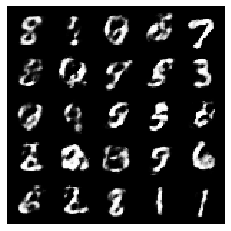

Epoch 156/200 ==> loss: -1.0329974493117393, gen_loss: -0.8793411489160666, disc_loss: -0.15365630039567268


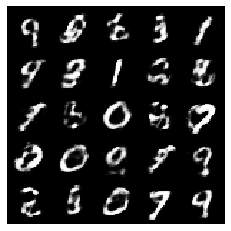

Epoch 157/200 ==> loss: -0.9595277420563497, gen_loss: -0.8072184888710705, disc_loss: -0.1523092531852792


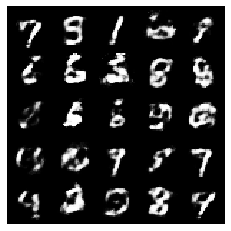

Epoch 158/200 ==> loss: -0.9981786167381888, gen_loss: -0.8458169388160846, disc_loss: -0.15236167792210414


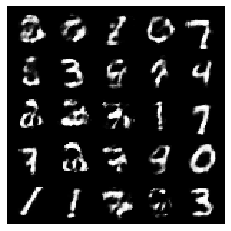

Epoch 159/200 ==> loss: -0.9958543474539107, gen_loss: -0.8444884128500818, disc_loss: -0.15136593460382883


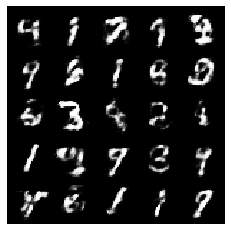

Epoch 160/200 ==> loss: -0.8663230141185537, gen_loss: -0.7177401465079466, disc_loss: -0.1485828676106071


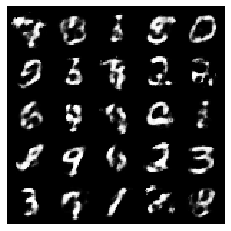

Epoch 161/200 ==> loss: -0.8704714387709741, gen_loss: -0.721442077778811, disc_loss: -0.14902936099216316


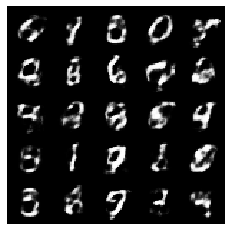

Epoch 162/200 ==> loss: -1.0267403217294753, gen_loss: -0.8795962845821486, disc_loss: -0.1471440371473267


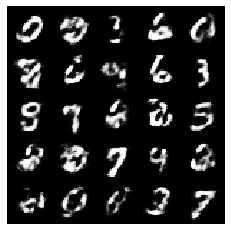

Epoch 163/200 ==> loss: -0.9521596810935402, gen_loss: -0.8045155731807897, disc_loss: -0.1476441079127505


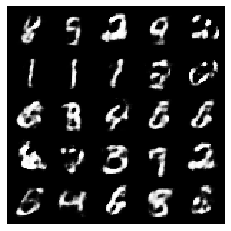

Epoch 164/200 ==> loss: -0.8510130499464066, gen_loss: -0.7057506128791481, disc_loss: -0.1452624370672585


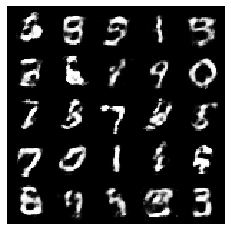

Epoch 165/200 ==> loss: -0.7627571766184714, gen_loss: -0.6192138840119189, disc_loss: -0.14354329260655252


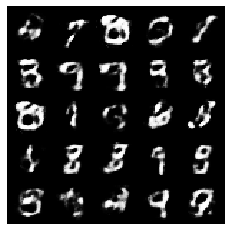

Epoch 166/200 ==> loss: -0.8419827169975371, gen_loss: -0.6976792240818415, disc_loss: -0.14430349291569572


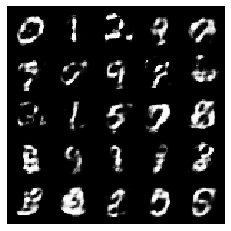

Epoch 167/200 ==> loss: -0.8927771445275225, gen_loss: -0.7515005790228382, disc_loss: -0.14127656550468431


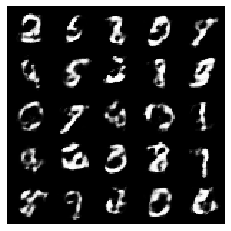

Epoch 168/200 ==> loss: -0.8464730697423493, gen_loss: -0.7085029673532769, disc_loss: -0.13797010238907237


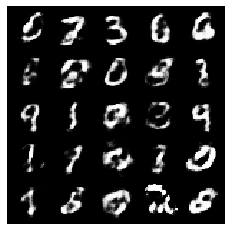

Epoch 169/200 ==> loss: -0.7914995299396829, gen_loss: -0.6504304278267367, disc_loss: -0.14106910211294618


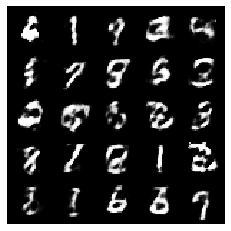

Epoch 170/200 ==> loss: -0.8642762628617191, gen_loss: -0.7232566831098832, disc_loss: -0.14101957975183588


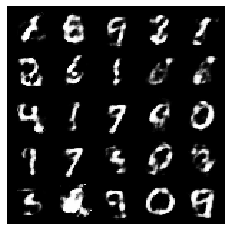

Epoch 171/200 ==> loss: -0.9160674281922293, gen_loss: -0.7785186367671276, disc_loss: -0.1375487914251017


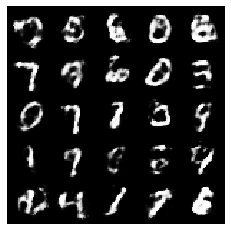

Epoch 172/200 ==> loss: -0.9773131904262076, gen_loss: -0.8393282883781837, disc_loss: -0.1379849020480238


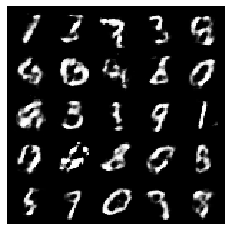

Epoch 173/200 ==> loss: -0.9606727933752908, gen_loss: -0.8232789334910879, disc_loss: -0.1373938598842028


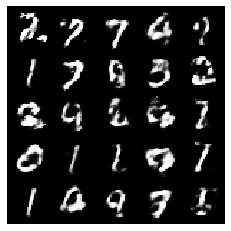

Epoch 174/200 ==> loss: -0.9056761958917272, gen_loss: -0.7690933810945403, disc_loss: -0.13658281479718698


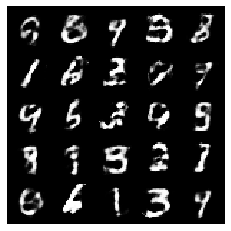

Epoch 175/200 ==> loss: -0.8481634869980855, gen_loss: -0.713459082615223, disc_loss: -0.1347044043828626


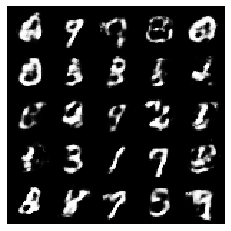

Epoch 176/200 ==> loss: -0.9289489939836088, gen_loss: -0.7940380841330157, disc_loss: -0.13491090985059304


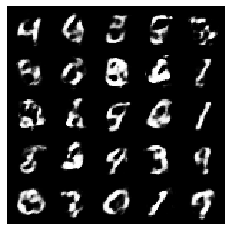

Epoch 177/200 ==> loss: -0.8122262771648289, gen_loss: -0.6775528687227796, disc_loss: -0.1346734084420492


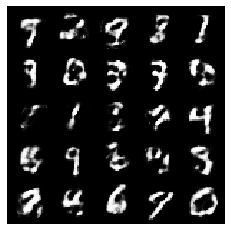

Epoch 178/200 ==> loss: -0.8118941841112413, gen_loss: -0.6772333717542331, disc_loss: -0.13466081235700814


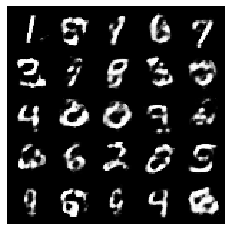

Epoch 179/200 ==> loss: -0.7749223445952483, gen_loss: -0.6405962931717554, disc_loss: -0.134326051423493


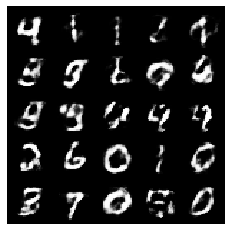

Epoch 180/200 ==> loss: -0.7867509345140928, gen_loss: -0.6526614126819144, disc_loss: -0.13408952183217845


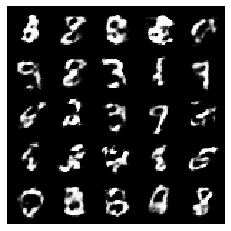

Epoch 181/200 ==> loss: -0.830482601901513, gen_loss: -0.6982108256498682, disc_loss: -0.1322717762516447


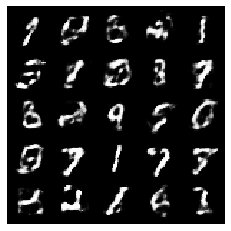

Epoch 182/200 ==> loss: -0.776496775679876, gen_loss: -0.6455063695663508, disc_loss: -0.1309904061135252


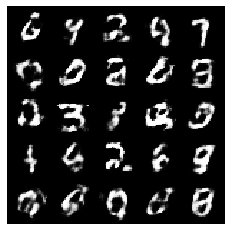

Epoch 183/200 ==> loss: -0.7801836534544581, gen_loss: -0.649360951546995, disc_loss: -0.130822701907463


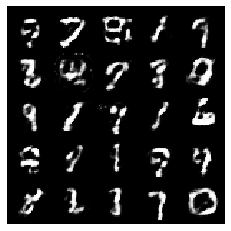

Epoch 184/200 ==> loss: -0.9519141394869719, gen_loss: -0.8226089564712218, disc_loss: -0.12930518301575014


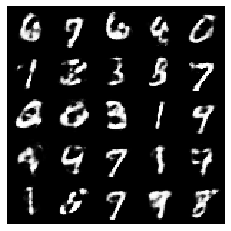

Epoch 185/200 ==> loss: -0.9204790550786355, gen_loss: -0.7913669405515277, disc_loss: -0.1291121145271078


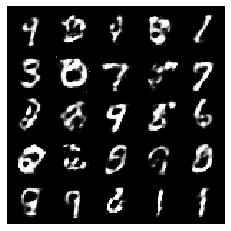

Epoch 186/200 ==> loss: -0.8550170859427513, gen_loss: -0.7257214260493597, disc_loss: -0.12929565989339156


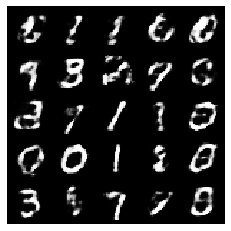

Epoch 187/200 ==> loss: -0.9839750008565635, gen_loss: -0.8551162036724893, disc_loss: -0.12885879718407417


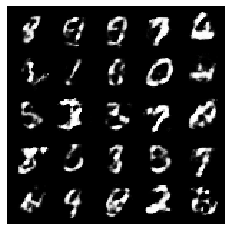

Epoch 188/200 ==> loss: -1.058196783828561, gen_loss: -0.9318174775383372, disc_loss: -0.1263793062902238


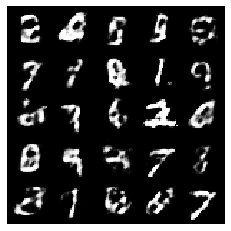

Epoch 189/200 ==> loss: -1.0235749340362479, gen_loss: -0.896198664766343, disc_loss: -0.1273762692699049


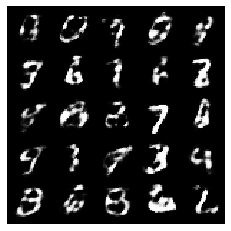

Epoch 190/200 ==> loss: -0.8472694477825757, gen_loss: -0.7225127782420658, disc_loss: -0.12475666954050989


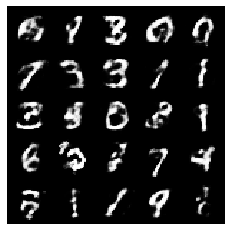

Epoch 191/200 ==> loss: -0.9579509158892867, gen_loss: -0.8344008150004818, disc_loss: -0.12355010088880494


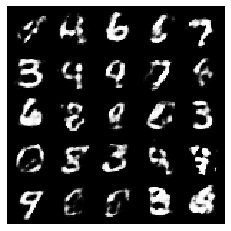

Epoch 192/200 ==> loss: -0.9035580131536864, gen_loss: -0.7801572398250238, disc_loss: -0.12340077332866257


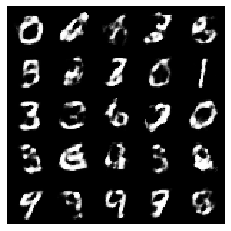

Epoch 193/200 ==> loss: -0.8425116697002808, gen_loss: -0.7174015271271387, disc_loss: -0.12511014257314218


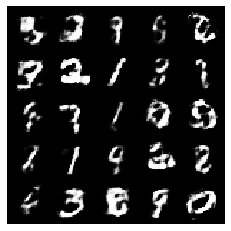

Epoch 194/200 ==> loss: -0.8551549570978886, gen_loss: -0.7322902142238791, disc_loss: -0.12286474287400952


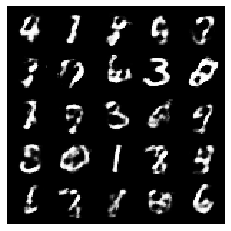

Epoch 195/200 ==> loss: -0.8933891632766131, gen_loss: -0.7720105145705466, disc_loss: -0.12137864870606654


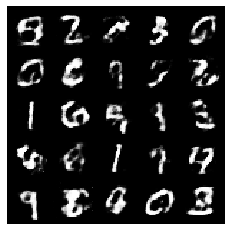

Epoch 196/200 ==> loss: -0.8138373940365842, gen_loss: -0.6933778380563098, disc_loss: -0.1204595559802744


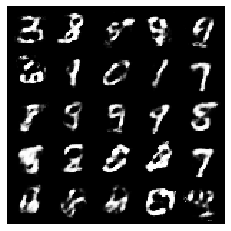

Epoch 197/200 ==> loss: -0.8121332725615562, gen_loss: -0.6902612965329256, disc_loss: -0.12187197602863067


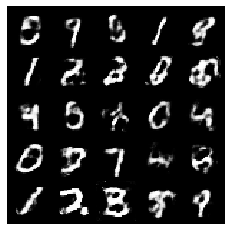

Epoch 198/200 ==> loss: -0.7550586531759398, gen_loss: -0.6341225206851959, disc_loss: -0.12093613249074388


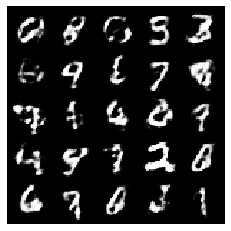

Epoch 199/200 ==> loss: -0.7703872871682239, gen_loss: -0.6519184224784266, disc_loss: -0.11846886468979732


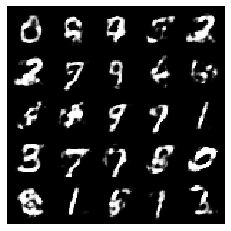

Epoch 200/200 ==> loss: -0.7602759323455733, gen_loss: -0.6436849689788748, disc_loss: -0.11659096336669852


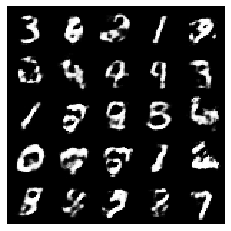

In [10]:
gen_losses, disc_losses = train_loop(
    generator, 
    discriminator,
    dataloader,
    optimizer_G,
    optimizer_D,
    wasserstein_loss,
    200,
    False,
    use_wasserstein=True
)

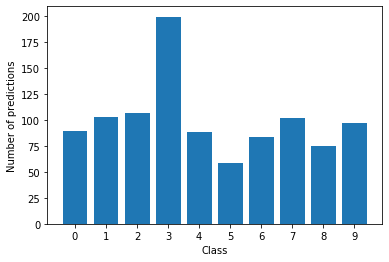

In [11]:
z = torch.randn((1000, latent_dim)).to(device)

# Generate a batch of images
with torch.no_grad():
    gen_imgs = generator(z)
    y_pred = clf(gen_imgs)
    
y_pred = np.argmax(y_pred.cpu().numpy(), axis=1)
plot_class_distributions(y_pred, 10)

# CGAN

In [12]:
# Initialize generator and discriminator
generator = Generator(10)
discriminator = Discriminator(10)

generator.to(device)
discriminator.to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

gen_losses, disc_losses = train_loop(
    generator, 
    discriminator,
    dataloader,
    optimizer_G,
    optimizer_D,
    bce_loss,
    20,
    True,
    use_wasserstein=False
)

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
z = torch.randn((1000, latent_dim)).to(device)

y = [i % 100 for i in range(1000)]

# Generate a batch of images
with torch.no_grad():
    y = torch.LongTensor([i % 10 for i in range(1000)]).to(device)
    y = to_onehot(y, 10)
    gen_imgs = generator(z, y)
    y_pred = clf(gen_imgs)
    
y_pred = np.argmax(y_pred.cpu().numpy(), axis=1)
plot_class_distributions(y_pred)

In [ ]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

n_epochs = 200
batch_size = 64
lr = 0.00005
n_cpu = 8
latent_dim = 100
img_size = 28
channels=1
n_critic = 5
clip_value = 0.01
sample_interval = 400

opt = {
    n_epochs: 200,
    batch_size: 64,
    lr: 0.00005,
    n_cpu: 8,
    latent_dim: 100,
    img_size: 28,
    channels: 1,
    n_critic: 5,
    clip_value: 0.01,
    sample_interval: 400
}

img_shape = (1, 28, 28)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.00005)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(200):

    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Train the generator every n_critic iterations
        if i % 5 == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()
            
            if batches_done % 400 == 0
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, 200, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
                )
            

        if batches_done % 400 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
        batches_done += 1